In [2]:
import pandas as pd 
import json
import azure.cosmos.cosmos_client as cosmos_client
import azure.cosmos.errors as errors
import azure.cosmos.documents as documents
import azure.cosmos.http_constants as http_constants

print('Imported packages successfully.')

Imported packages successfully.


In [3]:
# Initialize the Cosmos client

config = {
    "endpoint": "https://hdicosmosdb.documents.azure.com:443/",
    "primarykey": "e2MCvRHEBsflV42qQdwdqHgQDUdOf1r2xrv1W7uoXBob177yb8VeMsUZFbhGy2AqshEnviMyTBSfEaDkSHH9Lg=="
}

# Create the cosmos client
client = cosmos_client.CosmosClient(url_connection=config["endpoint"], auth={"masterKey":config["primarykey"]}
)

In [160]:
# Create a database
# https://docs.microsoft.com/en-us/python/api/azure-cosmos/azure.cosmos.cosmos_client.cosmosclient?view=azure-python#createdatabase-database--options-none-

database_name = 'HDIdatabase'
try:
    database = client.CreateDatabase({'id': database_name})
except errors.HTTPFailure:
    database = client.ReadDatabase("dbs/" + database_name)

In [163]:
# Create a collection of items in a Container
# Items are the individual rows/records of your dataset
# https://docs.microsoft.com/en-us/python/api/azure-cosmos/azure.cosmos.cosmos_client.cosmosclient?view=azure-python#createcontainer-database-link--collection--options-none-

database_link = 'dbs/' + 'HDIdatabase'
container_definition = {'id': 'HDIcontainer',
                        'partitionKey':
                                    {
                                        'paths': ['/country'],
                                        'kind': documents.PartitionKind.Hash
                                    }
                        }
try:
    container = client.CreateContainer(database_link=database_link, 
                                        collection=container_definition, 
                                        options={'offerThroughput': 400})
except errors.HTTPFailure as e:
    if e.status_code == http_constants.StatusCodes.CONFLICT:
        container = client.ReadContainer("dbs/" + database['id'] + "/colls/" + container_definition['id'])
    else:
        raise e

In [ ]:
# Download and read csv file
df = pd.read_csv('https://globaldatalab.org/assets/2019/09/SHDI%20Complete%203.0.csv',encoding='ISO-8859–1',dtype='str')
# Reset index - creates a column called 'index'
df = df.reset_index()
# Rename that new column 'id'
# Cosmos DB needs one column named 'id'. 
df = df.rename(columns={'index':'id'})
# Convert the id column to a string - this is a document database.
df['id'] = df['id'].astype(str)
df.info()

In [6]:
# Write rows of a pandas DataFrame as items to the Database Container

# https://docs.microsoft.com/en-us/python/api/azure-cosmos/azure.cosmos.cosmos_client.cosmosclient?view=azure-python#upsertitem-database-or-container-link--document--options-none-

# Create Connection Link string
database_link = 'dbs/' + 'HDIdatabase'
collection_link = database_link + '/colls/' + 'HDIcontainer'

# Write rows of a pandas DataFrame as items to the Database Container
for i in range(0,df.shape[0]):
    data_dict = dict(df.iloc[i,:])
    data_dict = json.dumps(data_dict)
    insert_data = client.UpsertItem(collection_link,json.loads(data_dict)
    )
print('Records inserted successfully.')

NameError: name 'df' is not defined

In [7]:
# Query Afghanistan records

# Create Connection Link string
database_link = 'dbs/' + 'HDIdatabase'
collection_link = database_link + '/colls/' + 'HDIcontainer'

for item in client.QueryItems(collection_link,
                              'SELECT VALUE count(c.id) FROM c where c.country="Afghanistan"',
                              {'enableCrossPartitionQuery': True}
                              ):
    print(json.dumps(item, indent=True))

144


In [8]:
# Initialize list
dflist = []
# Connection link
collection_link = database_link + '/colls/' + 'HDIcontainer'
# Write out query
query = 'SELECT * FROM c where c.country="Afghanistan" and c.level="National"'

# For-loop to retrieve individual json records from Cosmos DB 
# that satisfy our query
for item in client.QueryItems(collection_link,
                              query,
                              {'enableCrossPartitionQuery': True}
                              ):
    # Append each item as a dictionary to list
    dflist.append(dict(item))
    
# Convert list to pandas DataFrame
df = pd.DataFrame(dflist)
df.head()

,id,iso_code,country,year,GDLCODE,level,region,shdi,healthindex,incindex,...,lifexp,lgnic,esch,msch,pop,_rid,_self,_etag,_attachments,_ts
0,8,AFG,Afghanistan,2002,AFGt,National,Total,.372,.563,.357,...,56.6,6.967,6.5,2.3,21580,C1AmAIJ5WB8JAAAAAAAAAA==,dbs/C1AmAA==/colls/C1AmAIJ5WB8=/docs/C1AmAIJ5W...,"""18003c05-0000-0100-0000-5e406a140000""",attachments/,1581279764
1,17,AFG,Afghanistan,2003,AFGt,National,Total,.382,.574,.362,...,57.3,7.001,6.8,2.4,22520,C1AmAIJ5WB8SAAAAAAAAAA==,dbs/C1AmAA==/colls/C1AmAIJ5WB8=/docs/C1AmAIJ5W...,"""18005405-0000-0100-0000-5e406a140000""",attachments/,1581279764
2,26,AFG,Afghanistan,2004,AFGt,National,Total,.398,.583,.357,...,57.9,6.97,7.9,2.5,23460,C1AmAIJ5WB8bAAAAAAAAAA==,dbs/C1AmAA==/colls/C1AmAIJ5WB8=/docs/C1AmAIJ5W...,"""18006305-0000-0100-0000-5e406a150000""",attachments/,1581279765
3,35,AFG,Afghanistan,2005,AFGt,National,Total,.408,.592,.367,...,58.5,7.037,8.1,2.6,24400,C1AmAIJ5WB8kAAAAAAAAAA==,dbs/C1AmAA==/colls/C1AmAIJ5WB8=/docs/C1AmAIJ5W...,"""18007105-0000-0100-0000-5e406a150000""",attachments/,1581279765
4,44,AFG,Afghanistan,2006,AFGt,National,Total,.416,.602,.371,...,59.1,7.063,8.4,2.7,25120,C1AmAIJ5WB8tAAAAAAAAAA==,dbs/C1AmAA==/colls/C1AmAIJ5WB8=/docs/C1AmAIJ5W...,"""18007e05-0000-0100-0000-5e406a150000""",attachments/,1581279765


In [192]:
df.columns

Index(['id', 'iso_code', 'country', 'year', 'GDLCODE', 'level', 'region',
       'shdi', 'healthindex', 'incindex', 'edindex', 'lifexp', 'lgnic', 'esch',
       'msch', 'pop', '_rid', '_self', '_etag', '_attachments', '_ts'],
      dtype='object')

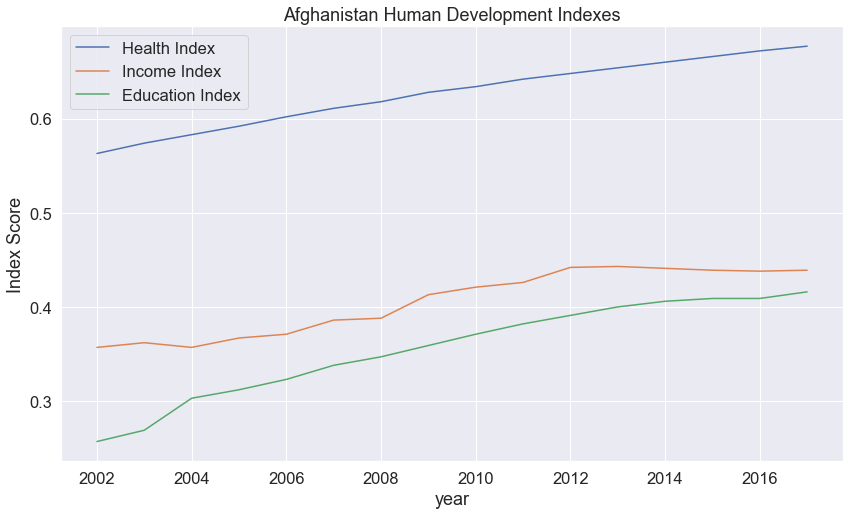

In [251]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Convert to type float
index_df = df.loc[:,('healthindex','incindex','edindex','year')].astype('float')

# Create the figure
plt.figure(figsize=(14,8))
# Set a Seaborn chart style
sns.set(style='darkgrid',font_scale=1.5)
# Plot three Seaborn line charts
line1 = sns.lineplot(x='year',y='healthindex',data=index_df, label='Health Index')
line2 = sns.lineplot(x='year',y='incindex',data=index_df,label='Income Index')
line3 = sns.lineplot(x='year',y='edindex',data=index_df,label='Education Index')
plt.ylabel('Index Score')
plt.legend(loc="upper left")
plt.title('Afghanistan Human Development Indexes')
plt.savefig('Afghanistan Indexes')
